<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Изучение-временного-ряда" data-toc-modified-id="Изучение-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Изучение временного ряда</a></span></li><li><span><a href="#Исследование-на-наличие-тренда,-сезонности-и-остатков" data-toc-modified-id="Исследование-на-наличие-тренда,-сезонности-и-остатков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Исследование на наличие тренда, сезонности и остатков</a></span></li><li><span><a href="#Проверка-на-стационарность-и-автокорреляция-ряда" data-toc-modified-id="Проверка-на-стационарность-и-автокорреляция-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на стационарность и автокорреляция ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Сделаем-тестовую-выборку-размером-10%-от-исходных-данных.--Добавим-дополнительные-признаки-во-временной-ряд." data-toc-modified-id="Сделаем-тестовую-выборку-размером-10%-от-исходных-данных.--Добавим-дополнительные-признаки-во-временной-ряд.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Сделаем тестовую выборку размером 10% от исходных данных.  Добавим дополнительные признаки во временной ряд.</a></span></li><li><span><a href="#Обучим-разные-модели-с-различными-гиперпараметрами." data-toc-modified-id="Обучим-разные-модели-с-различными-гиперпараметрами.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучим разные модели с различными гиперпараметрами.</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>LinearRegression</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LR-для-теста" data-toc-modified-id="LR-для-теста-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LR для теста</a></span></li><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>SARIMA</a></span></li><li><span><a href="#dummy" data-toc-modified-id="dummy-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>dummy</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import lightgbm as lgb
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

In [3]:
def model(features, target, param_grid, regr):
    # Создание модели и настройка с использованием решетчатого поиска 
    tscv = TimeSeriesSplit(n_splits=5)
    model = GridSearchCV(regr, param_grid, cv=tscv, n_jobs=-1, scoring = 'neg_root_mean_squared_error')
    start_time = datetime.now()
    model.fit(features, target)
    end_1_time = datetime.now()
    predictions = model.predict(features)
    predictions = pd.Series(predictions, index = features.index)
    end_2_time = datetime.now() 
    print('Время обучения модели:', end_1_time - start_time, 'секунд')
    print('Время предсказания модели:', end_2_time - end_1_time, 'секунд')
    print("Best Hyperparameters:", model.best_params_)
    print("Best Cross-Validation Score:", abs(model.best_score_))
    return model.best_params_, abs(model.best_score_), model.best_estimator_, predictions

In [4]:
def feature_importances(model):
    importances = model.feature_importances_
    importances = pd.Series(importances, index=features_test.columns).sort_values(ascending = False)
    importances = importances/importances.sum()
    print(importances)
    fig, ax = plt.subplots()
    importances.plot.bar(ax=ax)
    ax.set_title('Feature importances')
    ax.set_ylabel("feature_importances")

In [5]:
R_STATE = 12345

In [6]:
pth = '/datasets/taxi.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth, parse_dates=['datetime'])    
else:
    print('Ошибка в считывании данных из источника {}'.format(pth))

In [7]:
data_start = data.copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [8]:
data.head()

datetime  num_orders
0 2018-03-01 00:00:00           9
1 2018-03-01 00:10:00          14
2 2018-03-01 00:20:00          28
3 2018-03-01 00:30:00          20
4 2018-03-01 00:40:00          32

Отметки снимаются раз в 10 минут.

In [9]:
data.duplicated().sum()

0

В исходном датасете дубликатов не обнаружено

In [10]:
print(data['datetime'].min())
print(data['datetime'].max())

2018-03-01 00:00:00
2018-08-31 23:50:00


Работаем с отрезком времени с 1го марта по 31е августа. Это весна + лето. 
Давайте вычислим сколько точек должно быть в отрезке в 6 месяцев и 6 измерений в час.

In [11]:
print('Должно быть точек', (31 + 30 + 31 + 30 + 31 +31) * 24 * 6)
print('У нас точек ', len(data))

Должно быть точек 26496
У нас точек  26496


По количеству точек совпало

In [12]:
data.isnull().sum()

datetime      0
num_orders    0
dtype: int64

Пропусков нет. 

In [13]:
data.index = data['datetime']
data = data.drop(['datetime'],axis = 1)

**Дубликатов в данных нет, также нет и пропусков. Можно переходить к анализу и изучения временного ряда** 

## Анализ

### Изучение временного ряда

Давайте посмотрим на наш ряд


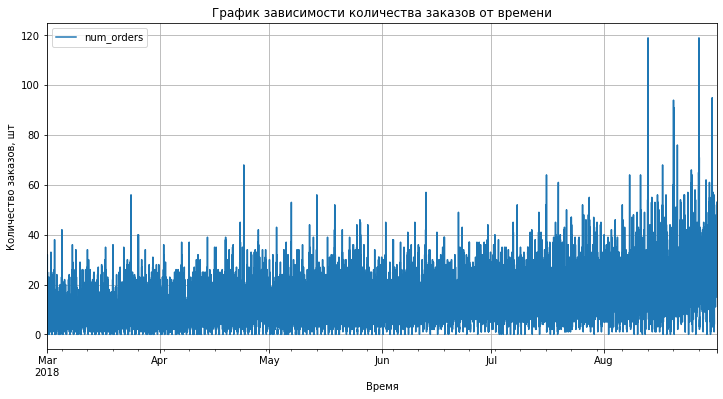

In [14]:
data.plot(figsize=(12,6))
# заголовок и подписи к осям
plt.title("График зависимости количества заказов от времени")
plt.ylabel('Количество заказов, шт')
plt.xlabel('Время')
 
# добавим сетку
plt.grid()
 
plt.show()

Ничего непонятно, кроме того, что количество заказов не бывает отрицательным. Давайте посмотрим кусочек данных. 

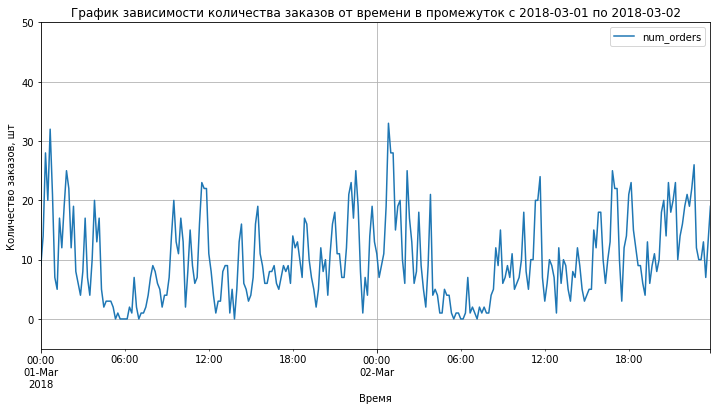

In [15]:
data['2018-03-01':'2018-03-02'].plot(figsize=(12,6))

# заголовок и подписи к осям
plt.title('График зависимости количества заказов от времени в промежуток с 2018-03-01 по 2018-03-02')
plt.ylabel('Количество заказов, шт')
plt.xlabel('Время')
plt.ylim (-5, 50) 
# добавим сетку
plt.grid()
 
plt.show()

Рассматривая 2 дня из жизни ряда можно заметить, что ночью заказов меньше. Пики приходятся на время после закрытия метро. 

Выполним ресемплирование по одному часу с функцией сумма. Нам важно знать скорее общее число заказов в следующий час, т.к. скорее всего схема 1 заказ - 1 водитель. 

In [16]:
data = data.resample('1H').sum()

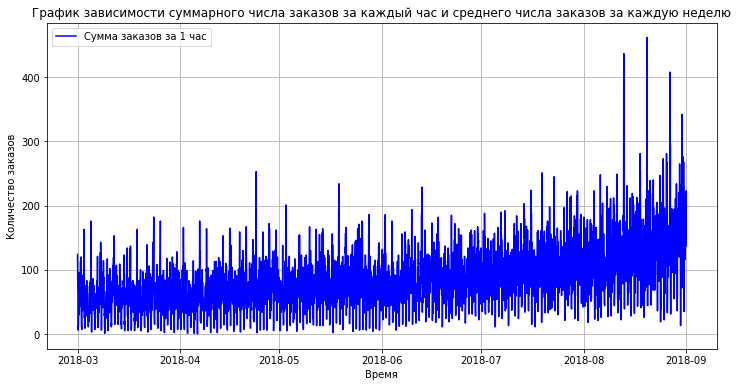

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(data, color = "b", label="Сумма заказов за 1 час")
#plt.plot(data.resample('1W').mean(), color = "red", label="Среднее число заказов за 1 неделю")
# заголовок и подписи к осям
plt.title('График зависимости суммарного числа заказов за каждый час и среднего числа заказов за каждую неделю')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
# добавим сетку
plt.grid()
plt.legend()
plt.show()

In [18]:
data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

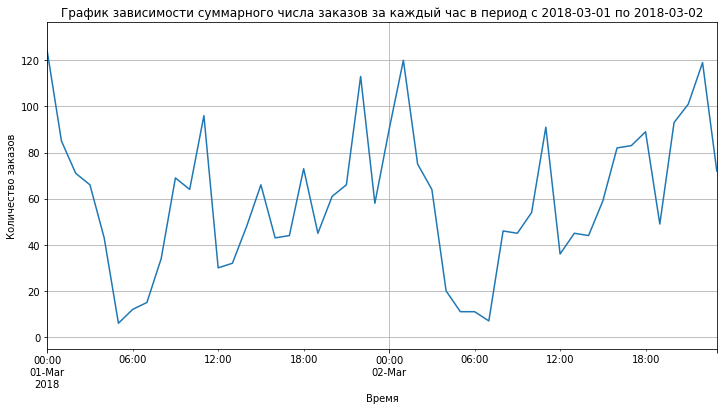

In [19]:
data['2018-03-01':'2018-03-02']['num_orders'].plot(figsize=(12,6))

plt.plot(data, color = "b", label="Сумма заказов за 1 час")
# заголовок и подписи к осям
plt.title('График зависимости суммарного числа заказов за каждый час в период с 2018-03-01 по 2018-03-02')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
# добавим сетку
plt.ylim (-5, data['2018-03-01':'2018-03-02']['num_orders'].max() * 1.1)
plt.grid()
plt.show()

Картинка стала чуть лучше. Давайте посмотрим, что у нас в среднем. 

In [20]:
def rolling_and_plot(data, rolling_mean_size):
    df = data.copy()
    df['rolling_mean'] = df.rolling(rolling_mean_size).mean()
    df['rolling_mean'].plot(figsize=(12,6))
    plt.title('Скользящее среднее размер {} часов'.format(rolling_mean_size))
    plt.ylabel('Количество заказов')
    plt.xlabel('Время')
    plt.ylim (0, df['rolling_mean'].max() * 1.1)

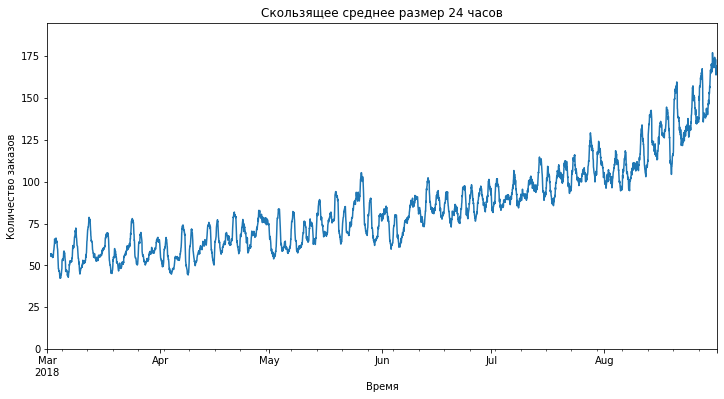

In [21]:
rolling_and_plot(data,24)

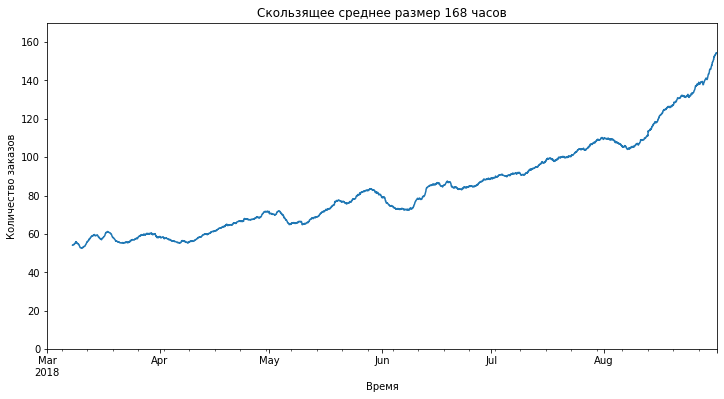

In [22]:
rolling_and_plot(data,168)

### Исследование на наличие тренда, сезонности и остатков

Наблюдаются как тренд (возрастание среднего числа суммарных заказов), так и сезонность с периодом в неделю и в сутки. 
Давайте попробуем отобразить это специальными инструментами.  

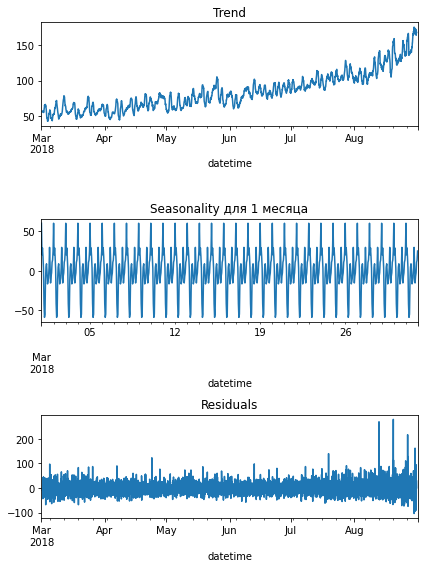

In [23]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax = plt.gca())
plt.title('Seasonality для 1 месяца')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

Действительно есть восходящий тренд, сезонность по дням и визуально равномерный шум. В августе есть странные выбросы. Наш ряд нельзя назвать стационарным и кажется можно назвать гомоскедастичным (постоянство дисперсии).

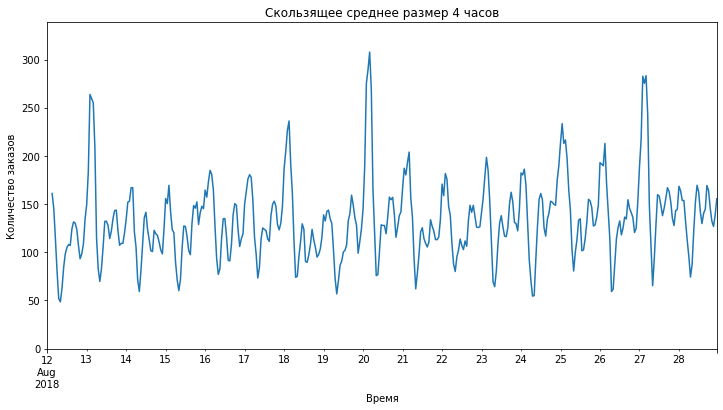

In [24]:
rolling_and_plot(data['2018-08-12':'2018-08-28'],4)

Выбросы приходятся на 13, 18, 20, 25, 27 августа. Это пятница и выходные. Люди возвращаются с отпуска? Студенты возвращаются с каникул?

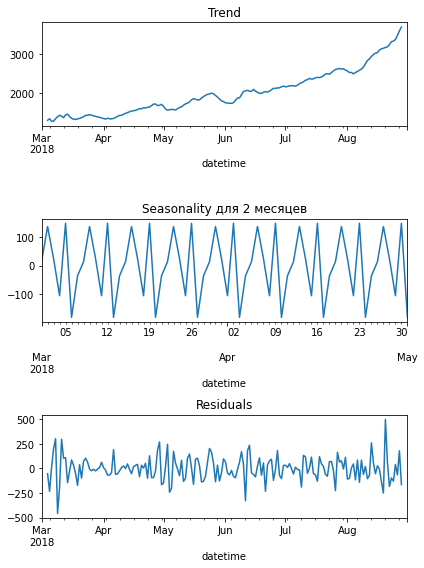

In [25]:
data_d = data.resample('1D').sum()
decomposed = seasonal_decompose(data_d)
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-05-01'].plot(ax = plt.gca())
plt.title('Seasonality для 2 месяцев')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

В данных наблюдается также недельная сезонность, что довольно логично для описываемого нами процесса. 

### Проверка на стационарность и автокорреляция ряда

Применим экспоненциальное сглаживание, модель Хольта-Винтерса

In [26]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [27]:
df = data['2018-03-01':'2018-03-31']['num_orders']

Рассмотрим один месяц из жизни временного ряда


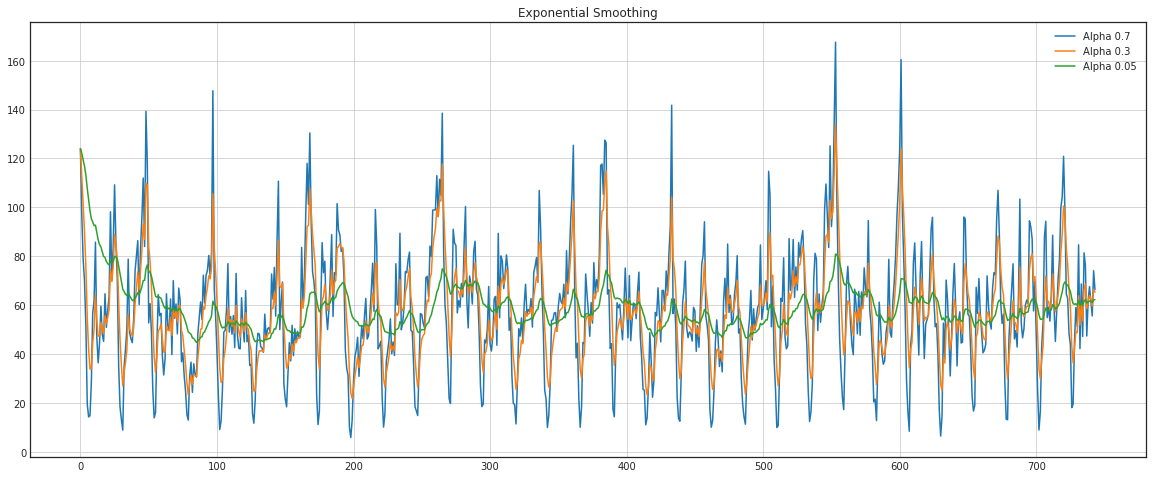

In [28]:
print('Рассмотрим один месяц из жизни временного ряда')
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.7, 0.3, 0.05]:
        plt.plot(exponential_smoothing(df, alpha), label="Alpha {}".format(alpha)) 
    #plt.plot(data['num_orders'].values, "c", label = "Actual")
    plt.legend(loc="best")
    #plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

Большая альфа сдвигает прогноз в сторону "завтра будет как сегодня", меньшая альфа дает больший вес прошлым измерениям и тем сильнее сглаживается ряд. 

In [29]:
def tsplot(y, lags=None,lags2=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        acf2_ax = plt.subplot2grid(layout, (2, 0))
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_acf(y, lags=lags2, ax=acf2_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        #print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

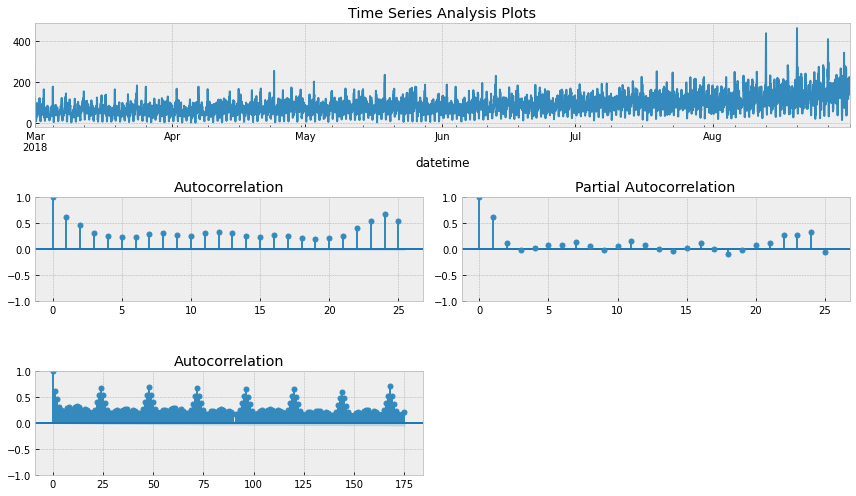

In [30]:
warnings.simplefilter(action = 'ignore', category = Warning)
tsplot(data['num_orders'], lags=25, lags2 = 175)

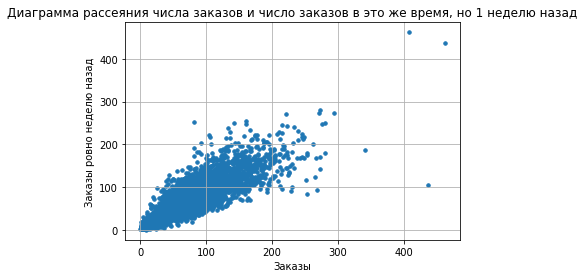

Коэффициент корреляции при этом составляет 0.805568759796653


In [31]:
 '''Визуализация корреляции между данными и сдвигом в 1 неделю'''
xs = data['num_orders']
ys = data['num_orders'].shift(168)
pd.DataFrame(np.array([xs,ys]).T).plot.scatter(0, 1, s=12, grid=True)
plt.title('Диаграмма рассеяния числа заказов и число заказов в это же время, но 1 неделю назад')
plt.xlabel('Заказы')
plt.ylabel('Заказы ровно неделю назад')
plt.show()
print('Коэффициент корреляции при этом составляет', xs.corr(ys))

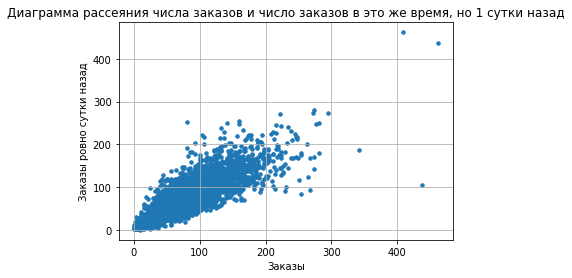

Коэффициент корреляции при этом составляет 0.6915757091783526


In [32]:
 '''Визуализация корреляции между данными и сдвигом в 1 день'''
xs = data['num_orders']
zs = data['num_orders'].shift(24)
pd.DataFrame(np.array([xs,ys]).T).plot.scatter(0, 1, s=12, grid=True)
plt.title('Диаграмма рассеяния числа заказов и число заказов в это же время, но 1 сутки назад')
plt.xlabel('Заказы')
plt.ylabel('Заказы ровно сутки назад')
plt.show()
print('Коэффициент корреляции при этом составляет', xs.corr(zs))

В частности, мы видим, что автокорреляция ряда с самим собой (первый столбец) равна 1, что логично. Второй столбец (то есть лаг 1) как раз примерно равен – 0,7.
Лаг 24 тоже имеет большую корреляцию с исходным рядом (что в целом логично, показания с разницей в сутки коррелируют положительно и достаточно сильно). Значительную корреляцию также имеет недельный сдвиг, будем брать его для предсказания модели. 

Попробуем лучше понять поведение нашего ряда применив специальные тесты. 

Критерий Дики-Фуллера.

    Нулевая гипотеза (H0): предполагает, что временной ряд нестационарный
    Альтернативная гипотеза (H1): предполагает, что временной ряд стационарный

In [33]:
test = sm.tsa.stattools.adfuller(data['num_orders'])
print("Критерий Дики-Фуллера: p={}".format(test[1])) 

Критерий Дики-Фуллера: p=0.028940051402612906


p-value достаточно мало, мы можем отвергнуть нулевую гипотезу о НЕстационарности ряда на уровне значимости 0.05. Считаем, что ряд стационарный. 

Распределение похоже на Пуассоновское. 

**Вывод. Наш ряд имеет тренд, сезонность и скорее всего примерно постоянный шум. Не смотря на результаты стат. теста (отвергли гипотезу о нестационарности), будем считать, что тренд у нас есть и он возрастающий, сезонность тоже очень выраженна. Были обнаружены высокие уровни автокорреляции при сдвиге на 1 час и 24 часа и 168 часов. При построении можели эта информация будем нам полезна. Если говорить терминами сезонности, то она была обнаруженая для периодов 1 день и 1 неделя.** 

## Обучение

### Сделаем тестовую выборку размером 10% от исходных данных.  Добавим дополнительные признаки во временной ряд. 

Год не будет являться признаком, т.к. он постоянен в наших данных. 

In [35]:
def make_features(data, rolling_mean_size, lag_1, lag_2):
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    for lag in [lag_1,lag_2]:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag) #, fill_value=0   
        
    data = data.dropna()
    return data

In [36]:
data = make_features(data, 168, 168, 24)
data = data.T.drop_duplicates().T
data[['hour','num_orders','dayofweek']] = data[['hour','num_orders','dayofweek']].astype (int)
data = data.rename(columns={'rolling_mean':'rolling_mean_{}'.format(168)})
print(data.head())

                     num_orders  dayofweek  hour  rolling_mean_168  lag_168  \
datetime                                                                      
2018-03-08 00:00:00         143          3     0         54.226190    124.0   
2018-03-08 01:00:00          78          3     1         54.339286     85.0   
2018-03-08 02:00:00          65          3     2         54.297619     71.0   
2018-03-08 03:00:00          68          3     3         54.261905     66.0   
2018-03-08 04:00:00          60          3     4         54.273810     43.0   

                     lag_24  
datetime                     
2018-03-08 00:00:00   100.0  
2018-03-08 01:00:00   121.0  
2018-03-08 02:00:00    24.0  
2018-03-08 03:00:00    66.0  
2018-03-08 04:00:00    73.0  


In [37]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
print('Длина трейна',train.shape[0])
print('Длина теста',test.shape[0])

2018-03-08 00:00:00 2018-08-14 06:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00
Длина трейна 3823
Длина теста 425


Разбиение прошло успешно, данные стыкуются. 

In [38]:
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders'] 

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

### Обучим разные модели с различными гиперпараметрами. 

Во всех моделях где использовался GridSearchCV отсутствовала кросс-валидация, т.к. во временных рядах ее делают особым образом. В наших моделях кросс-валидация не осуществлялась. 

Отберем серии для построения графиков

In [39]:
g_train = data.query('index in @train.index')['num_orders']
g_test = data.query('index in @test.index')['num_orders']

#### RandomForestRegressor

In [40]:
%%time
param_grid_RFR = {
    'n_estimators': np.arange(10, 100, step=20),
    'max_depth': list(np.arange(2, 7, step=2)) + [None]
    }
RFR_regr = RandomForestRegressor(random_state = R_STATE)
RFR_param, RFR_rmse, RFR_best_model, RFR_pred = model(features_train, target_train, param_grid_RFR, RFR_regr)

Время обучения модели: 0:00:16.712435 секунд
Время предсказания модели: 0:00:00.022364 секунд
Best Hyperparameters: {'max_depth': 4, 'n_estimators': 90}
Best Cross-Validation Score: 24.92494963259147
CPU times: user 16.7 s, sys: 53.3 ms, total: 16.7 s
Wall time: 16.7 s


lag_168             0.880548
lag_24              0.072685
rolling_mean_168    0.032208
hour                0.014372
dayofweek           0.000186
dtype: float64


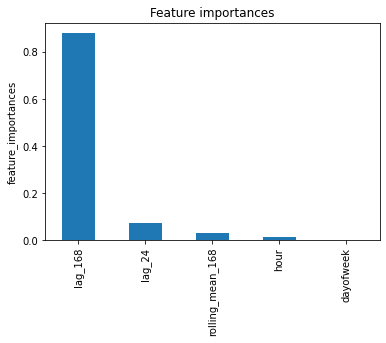

In [41]:
feature_importances(RFR_best_model)

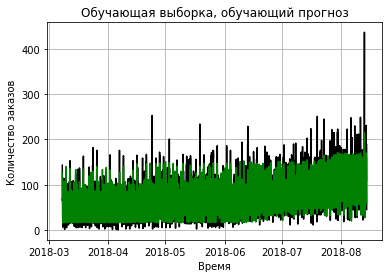

In [42]:
plt.plot(g_train, color = "black")
plt.plot(RFR_pred, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, обучающий прогноз")
plt.ylabel('Количество заказов')
plt.xlabel('Время')
 
# добавим сетку
plt.grid()
 
plt.show()

#### LightGBM

In [43]:
features_train_LGB = features_train.copy()
features_test_LGB = features_test.copy()
category = ['hour','dayofweek']
for cat in category:
    features_train_LGB[cat] = features_train_LGB[cat].astype('category')
    features_test_LGB[cat] = features_test_LGB[cat].astype('category')

In [44]:
%%time
param_grid_LGB = {
    'n_estimators': np.arange(10, 200, step=30),
    'max_depth': list(np.arange(2, 7, step=2)) + [None]
    }
LGB_regr = lgb.LGBMRegressor(random_state = R_STATE)
LGB_param, LGB_rmse, LGB_best_model, LGB_pred = model(features_train_LGB, target_train, param_grid_LGB, LGB_regr)

Время обучения модели: 0:01:21.383930 секунд
Время предсказания модели: 0:00:00.094908 секунд
Best Hyperparameters: {'max_depth': 2, 'n_estimators': 40}
Best Cross-Validation Score: 24.903548121536062
CPU times: user 1min 18s, sys: 982 ms, total: 1min 19s
Wall time: 1min 21s


hour                0.398305
lag_168             0.271186
rolling_mean_168    0.228814
lag_24              0.076271
dayofweek           0.025424
dtype: float64


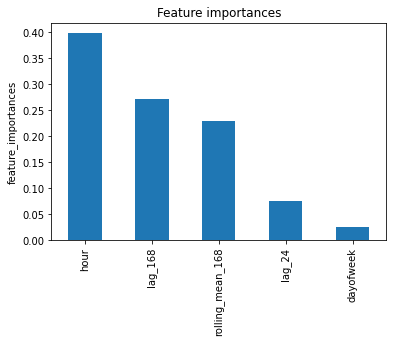

In [45]:
feature_importances(LGB_best_model)

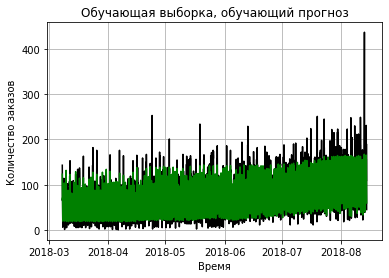

In [46]:
plt.plot(g_train, color = "black")
plt.plot(LGB_pred, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, обучающий прогноз")
plt.ylabel('Количество заказов')
plt.xlabel('Время')
 
# добавим сетку
plt.grid()
 
plt.show()

#### LinearRegression

In [47]:
pd.options.mode.chained_assignment = None
features_train_LR = features_train.copy()
features_test_LR = features_test.copy()
scaler = StandardScaler()
scaler.fit(features_train_LR)

features_train_LR = scaler.transform(features_train_LR)
features_test_LR = scaler.transform(features_test_LR)
features_train_LR = pd.DataFrame(features_train_LR, index = features_train.index, columns = features_train.columns)
features_test_LR = pd.DataFrame(features_test_LR, index = features_test.index, columns = features_test.columns)

In [48]:
%%time
param_grid_LR = {}
LR_regr = LinearRegression()
LR_param, LR_rmse, LR_best_model, LR_pred = model(features_train_LR, target_train, param_grid_LR, LR_regr)

Время обучения модели: 0:00:00.027532 секунд
Время предсказания модели: 0:00:00.001590 секунд
Best Hyperparameters: {}
Best Cross-Validation Score: 24.124613861663097
CPU times: user 30.8 ms, sys: 4.07 ms, total: 34.9 ms
Wall time: 29.6 ms


lag_168             0.649821
lag_24              0.286794
rolling_mean_168    0.091094
hour               -0.009732
dayofweek          -0.017978
dtype: float64



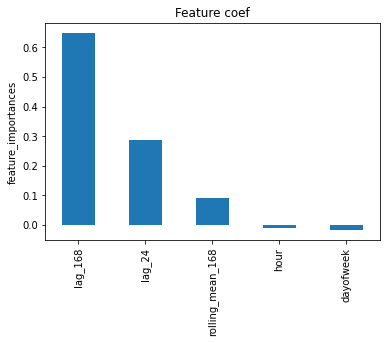

In [49]:
importances = LR_best_model.coef_
importances = pd.Series(importances, index=features_test.columns).sort_values(ascending = False)
importances = importances/importances.sum()
print(importances)
fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title('Feature coef')
ax.set_ylabel("feature_importances")
print()

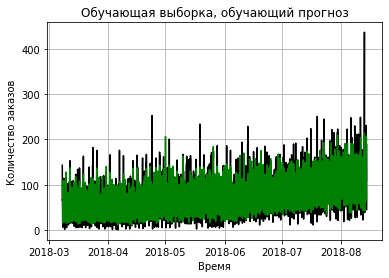

In [50]:
# выведем две кривые (обучающая, тестовая выборка и тестовый прогноз)

plt.plot(g_train, color = "black")
plt.plot(LR_pred, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, обучающий прогноз")
plt.ylabel('Количество заказов')
plt.xlabel('Время')
 
# добавим сетку
plt.grid()
 
plt.show()

**Вывод. Мы выделили 10% конца временного ряда на тест и добавили в качестве переменных сдвиги на 24 часа и 168 часов (сутки и неделя), скользящее среднее за 168 часов, дни недели и номер часа. По полученным Х обучили и проверили на трейне несколько моделей. Модель RFR показала достаточно хороший результат по rmse, как и LightGBM. Также при изучении важности предикторов в модели было выяснено, что в модели RFR большим весом обладает сдвиг на 168 часов, а остальные предикторы играют меньшую роль. В модели LightGMB роли предикторов различаются не так значительно, несколько Х имеют высокую значимость.** 

**Модель линейной регрессии показала лучший RMSE (но очень близко к другим), и адекватные коэффициенты (при условии стандартизации данных). Первое место занял предиктор "сдвиг на 168 часов".**

**Для теста была выбрана модель LR, показавшая лучшие значения rmse в обучении. Заметим, что модели RFR и LightGBM также являются перспективными для теста в нашей ситуации, как имеющие большое число гиперпараметров для дальнейшего развития и настройки.**

## Тестирование

### LR для теста

In [51]:
LR_regr = LinearRegression()
LR_regr.fit(features_train_LR, target_train,)
predictions_LR = LR_regr.predict(features_test_LR)
LR_rmse = mean_squared_error(target_test, predictions_LR) ** 0.5
print('rmse для LR модели на тесте :', LR_rmse) 

rmse для LR модели на тесте : 35.71073498550582


In [52]:
print('отношение ошибки к среднему на тесте :', LGB_rmse/target_test.mean())

отношение ошибки к среднему на тесте : 0.17777193932601282


Попробуем также применить специализированный метод для анализа временных рядов.

### SARIMA

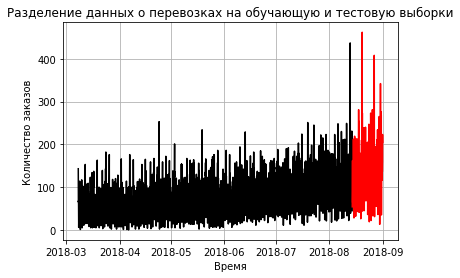

In [53]:
plt.plot(g_train, color = "black")
plt.plot(g_test, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
 
# добавим сетку
plt.grid()
 
plt.show()

In [54]:
warnings.simplefilter(action = 'ignore', category = Warning)

# обучим модель с соответствующими параметрами, SARIMAX(0, 0, 0)x(2, 1, 0, 24)
# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# создадим объект этой модели
S_model = SARIMAX(g_train, 
                order = (0, 0, 0), 
                seasonal_order = (2, 1, 0, 12))
 
# применим метод fit
result = S_model.fit()
# тестовый прогнозный период начнется с конца обучающего периода
start = len(g_train)
 
# и закончится в конце тестового
end = len(g_train) + len(g_test) - 1
  
# применим метод predict
predictions = result.predict(start, end)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82004D+00    |proj g|=  6.39778D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      4      1     0     0   3.035D-05   4.820D+00
  F =   4.8200425214790217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


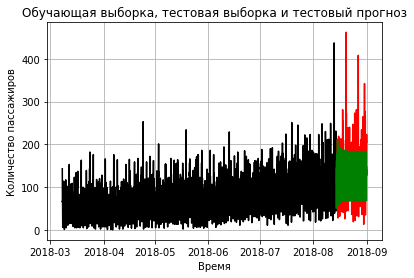

In [55]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(g_train, color = "black")
plt.plot(g_test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Время')
 
# добавим сетку
plt.grid()
 
plt.show()

In [56]:
print('rmse для SARIMA модели на тесте :', np.sqrt(mean_squared_error(g_test, predictions)))

rmse для SARIMA модели на тесте : 59.333509536939175


### dummy

In [57]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_regr_test_predictions = dummy_regr.predict(features_test)
dummy_rmse = mean_squared_error(target_test, dummy_regr_test_predictions) ** 0.5
print('rmse для dummy модели на тесте :', dummy_rmse) 

rmse для dummy модели на тесте : 84.45113423436631


**Вывод. В данном проекте мы строили модель для предсказания числа заказов на ближайший час. Само предсказание за пределы выданных временых отрезков нами не делалось, но мы проверяли работу моделей на тестовых данных.
Выбранная нами модель LR показала rmse равный 35, как и требовалось в условии. Но стоит заметить, что данная ошибка порядка 17% от среднего значения на тесте.** 